In [ ]:
!pip install --force-reinstall albumentations==1.0.3

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [3]:
DATA_DIR = 'D:/Molavi/Data_Mass_Building/tiff/Div_Data_2/'

x_train_dir = os.path.join(DATA_DIR, 'Train_images')
y_train_dir = os.path.join(DATA_DIR, 'Train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'Val_images')
y_valid_dir = os.path.join(DATA_DIR, 'Val_labels')

#x_test_dir = os.path.join(DATA_DIR, 'Test_images')
#y_test_dir = os.path.join(DATA_DIR, 'Test_labels')

In [4]:
class_dict = pd.read_csv("D:/Molavi/Data_Mass_Building/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [6]:
# Helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize = (20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # Get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize = 20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis = -1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.

    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
class BuildingsDataset(torch.utils.data.Dataset):
    """
    Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Arguments:
        images_dir (str) : path to images folder
        masks_dir (str) : path to segmentation masks folder
        class_rgb_values (list) : RGB values of select classes to extract from segmentation mask 
        augmentation (albumentations.Compose) : data transfromation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose) : data preprocessing (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values = None, 
            augmentation = None, 
            preprocessing = None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # One-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # Return length 
        return len(self.image_paths)

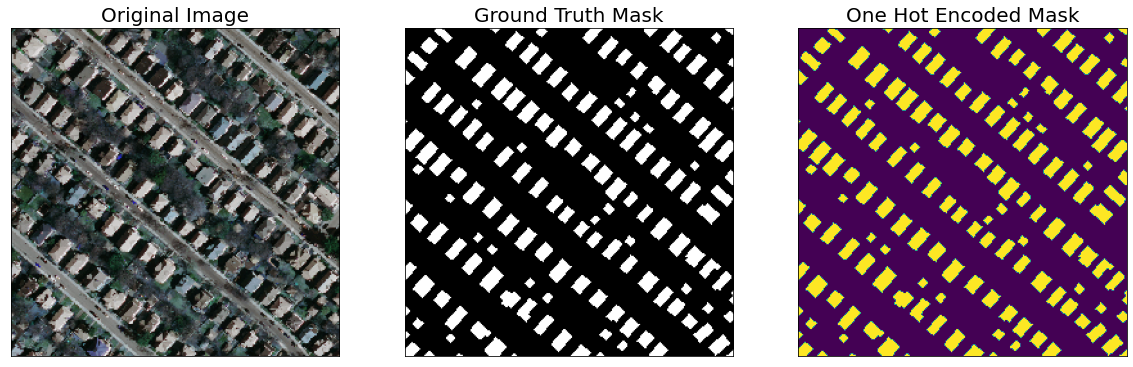

In [8]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values = select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [9]:
def get_training_augmentation():
    train_transform = [    
        #album.RandomCrop(height = 256, width = 256, always_apply = True),
        album.OneOf(
            [
                album.HorizontalFlip(p = 1),
                album.VerticalFlip(p = 1),
                album.RandomRotate90(p = 1),
            ],
            p = 0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        #album.PadIfNeeded(min_height = 1536, min_width = 1536, always_apply = True, border_mode = 0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """
    Construct preprocessing transform    
    
    Arguments:
        preprocessing_fn (callable): data normalization function (can be specific for each pretrained neural network)
    Returns:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image = preprocessing_fn))
    _transform.append(album.Lambda(image = to_tensor, mask = to_tensor))
        
    return album.Compose(_transform)

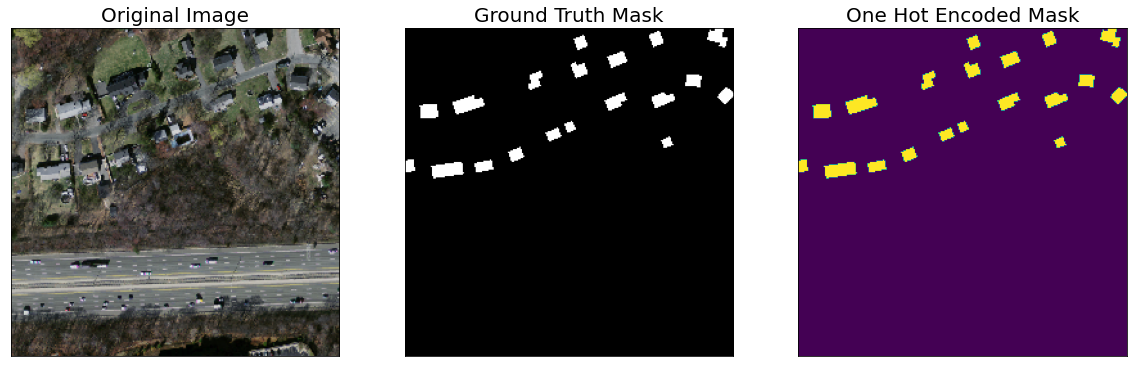

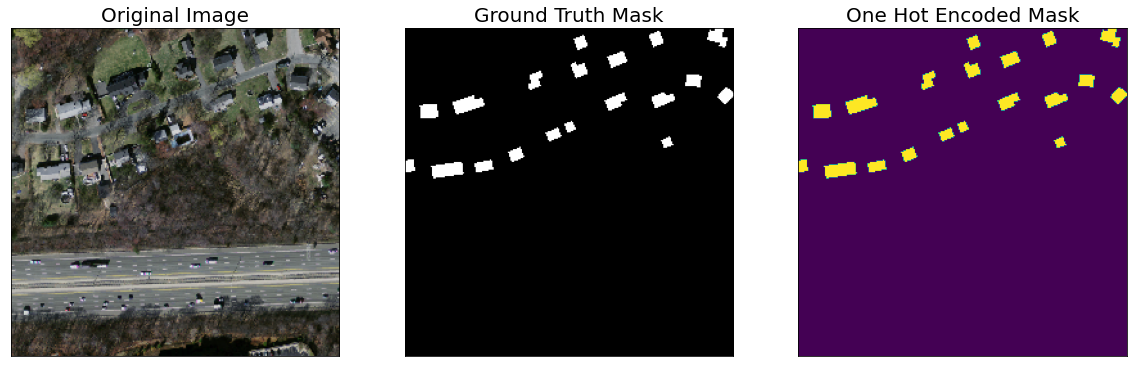

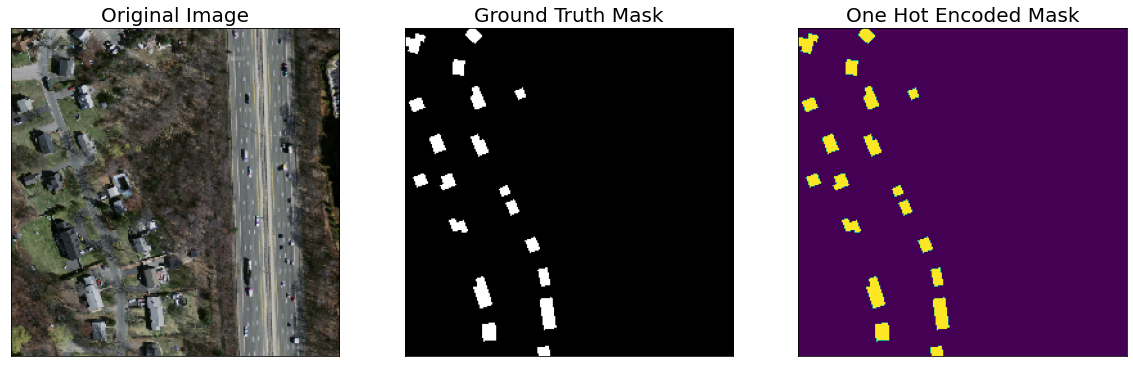

In [10]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = get_training_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on a random image / mask pair (256 * 256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [11]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

# Create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name = ENCODER, 
    encoder_weights = ENCODER_WEIGHTS, 
    classes = len(CLASSES), 
    activation = ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
# Get train and validation dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

# Get train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False, num_workers = 0)

In [13]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set number of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function
loss = smp.utils.losses.DiceLoss()

# Define metrics
metrics = [
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.IoU(threshold = 0.5),
    smp.utils.metrics.Fscore(eps=1.),

]

# Define optimizer
optimizer = torch.optim.Adam([ 
    dict(params = model.parameters(), lr = 0.0001),
])

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0 = 1, T_mult = 2, eta_min = 5e-5,
)

# Load best saved model checkpoint from previous commit (if present)
#if os.path.exists('../input/unet-with-pretrained-effnet-encoder-pytorch/best_model.pth'):
#    model = torch.load('../input/unet-with-pretrained-effnet-encoder-pytorch/best_model.pth', map_location = DEVICE)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    device = DEVICE,
    verbose = True,
)

In [15]:
%%time
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        writer.add_scalars(f'loss/Train_Val', {'Train_dice_loss': train_logs.get('dice_loss'),
                       'Val_dice_loss': valid_logs.get('dice_loss')}, i)
        writer.add_scalars(f'Accuracy/Train_Val', {'Train_accuracy': train_logs.get('accuracy'),
                       'Val_accuracy': valid_logs.get('accuracy')}, i)
        writer.add_scalars(f'IOU/Train_Val', {'Train_iou': train_logs.get('iou_score'),
                       'Val_iou': valid_logs.get('iou_score')}, i)
        writer.add_scalars(f'F1/Train_Val', {'Train_f1': train_logs.get('fscore'),
                       'Val_f1': valid_logs.get('fscore')}, i)
        
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['fscore']:
            best_iou_score = valid_logs['fscore']
            torch.save(model, 'D:/Molavi/Data_Mass_Building/Models/UnetPlus_Effnet/UnetPlus_Effnet.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2733/2733 [03:58<00:00, 11.46it/s, dice_loss - 0.06513, accuracy - 0.9414, iou_score - 0.8927, fscore - 0.9413]
Model saved!

Epoch: 1
valid: 100%|██████████| 2733/2733 [03:13<00:00, 14.12it/s, dice_loss - 0.05798, accuracy - 0.944, iou_score - 0.8971, fscore - 0.9439] 
Model saved!

Epoch: 2
valid: 100%|██████████| 2733/2733 [03:14<00:00, 14.03it/s, dice_loss - 0.05396, accuracy - 0.9471, iou_score - 0.9024, fscore - 0.9469]
Model saved!

Epoch: 3
valid: 100%|██████████| 2733/2733 [03:14<00:00, 14.08it/s, dice_loss - 0.05315, accuracy - 0.9475, iou_score - 0.9031, fscore - 0.9474]
Model saved!

Epoch: 4
valid: 100%|██████████| 2733/2733 [03:10<00:00, 14.33it/s, dice_loss - 0.05118, accuracy - 0.9492, iou_score - 0.9061, fscore - 0.9491]
Model saved!

Epoch: 5
valid: 100%|██████████| 2733/2733 [03:14<00:00, 14.02it/s, dice_loss - 0.05066, accuracy - 0.9497, iou_score - 0.9068, fscore - 0.9496]
Model saved!

Epoch: 6
valid: 100%|██████████| 2733/2733 [0

valid: 100%|██████████| 2733/2733 [03:11<00:00, 14.29it/s, dice_loss - 0.04254, accuracy - 0.9576, iou_score - 0.9207, fscore - 0.9575]

Epoch: 28
valid: 100%|██████████| 2733/2733 [03:15<00:00, 14.00it/s, dice_loss - 0.04245, accuracy - 0.9577, iou_score - 0.9209, fscore - 0.9576]

Epoch: 29
valid: 100%|██████████| 2733/2733 [03:13<00:00, 14.15it/s, dice_loss - 0.04181, accuracy - 0.9584, iou_score - 0.9219, fscore - 0.9582]
Model saved!

Epoch: 30
valid: 100%|██████████| 2733/2733 [03:11<00:00, 14.25it/s, dice_loss - 0.04166, accuracy - 0.9585, iou_score - 0.9221, fscore - 0.9584]
Model saved!

Epoch: 31
valid: 100%|██████████| 2733/2733 [03:15<00:00, 13.98it/s, dice_loss - 0.04136, accuracy - 0.9588, iou_score - 0.9226, fscore - 0.9587]
Model saved!

Epoch: 32
valid: 100%|██████████| 2733/2733 [03:12<00:00, 14.19it/s, dice_loss - 0.04102, accuracy - 0.9592, iou_score - 0.9232, fscore - 0.959] 
Model saved!

Epoch: 33
valid: 100%|██████████| 2733/2733 [03:14<00:00, 14.02it/s, dice_lo

**Prediction On Test Data**

In [ ]:
# Load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location = DEVICE)
    print('Loaded UNet model from this run.')

# Load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location = DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


In [ ]:
# Create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    class_rgb_values = select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation = get_validation_augmentation(),
    class_rgb_values = select_class_rgb_values,
)

# Get a random test image / mask index
random_idx = random.randint(0, len(test_dataset_vis) - 1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536 * 1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose convolution operations).

In [ ]:
# Center crop padded image / mask to original image dimensions
def crop_image(image, target_image_dims = [1500, 1500, 3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

**Model Evaluation On Test Dataset**

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss, 
    metrics = metrics, 
    device = DEVICE,
    verbose = True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s, dice_loss - 0.2879, iou_score - 0.7186]
Evaluation on Test Data: 
Mean IoU Score: 0.7186
Mean Dice Loss: 0.2879


**Dice Loss & IoU Metrics**

In [16]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dice_loss,0.114985,0.061956,0.056083,0.053315,0.051645,0.050473,0.049436,0.048420,0.047768,0.047128,...,0.036853,0.036555,0.036312,0.036126,0.035992,0.035698,0.035529,0.035221,0.035025,0.035206
accuracy,0.922144,0.941948,0.945490,0.947535,0.948888,0.949905,0.950848,0.951809,0.952432,0.953056,...,0.963276,0.963572,0.963817,0.964001,0.964135,0.964430,0.964598,0.964905,0.965102,0.964921
iou_score,0.857533,0.890582,0.896888,0.900571,0.902996,0.904817,0.906515,0.908260,0.909394,0.910505,...,0.929176,0.929736,0.930195,0.930523,0.930781,0.931320,0.931621,0.932201,0.932578,0.932228
fscore,0.922015,0.941848,0.945400,0.947453,0.948811,0.949829,0.950772,0.951735,0.952356,0.952977,...,0.963178,0.963475,0.963718,0.963903,0.964037,0.964332,0.964500,0.964806,0.965003,0.964822


**Plotting The Performance Metrics**

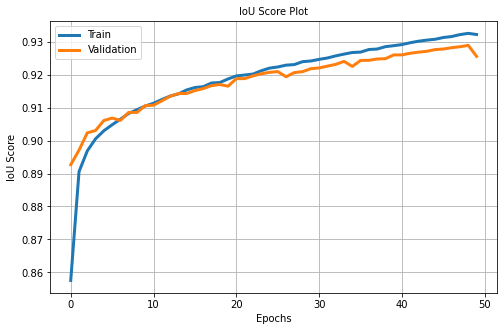

In [27]:
plt.figure(figsize = (8, 5))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw = 3, label = 'Validation')
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('IoU Score', fontsize = 10)
plt.title('IoU Score Plot', fontsize = 10)
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

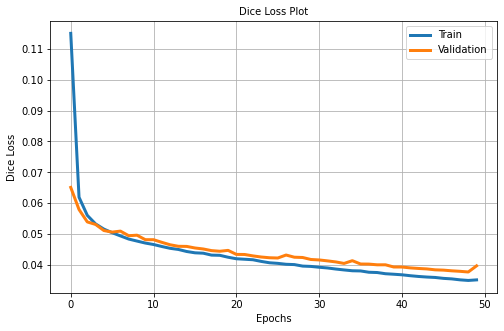

In [28]:
plt.figure(figsize = (8, 5))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw = 3, label = 'Validation')
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Dice Loss', fontsize = 10)
plt.title('Dice Loss Plot', fontsize = 10)
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

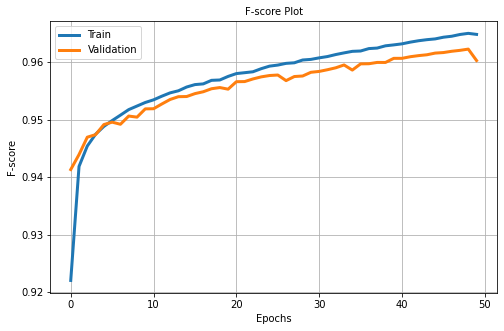

In [29]:
plt.figure(figsize = (8, 5))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw = 3, label = 'Validation')
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('F-score', fontsize = 10)
plt.title('F-score Plot', fontsize = 10)
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.savefig('Fscore_plot.png')
plt.show()

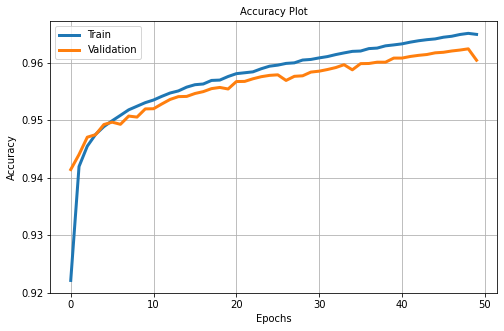

In [30]:
plt.figure(figsize = (8, 5))
plt.plot(train_logs_df.index.tolist(), train_logs_df.accuracy.tolist(), lw = 3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.accuracy.tolist(), lw = 3, label = 'Validation')
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Plot', fontsize = 10)
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.savefig('Accuracy_plot.png')
plt.show()